#### copying a lot of code from average_rf.ipynb -- need to clean this up

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np


import os, glob
from pathlib import Path

from dandi import dandiapi
from pynwb import NWBHDF5IO
from dandi.dandiapi import DandiAPIClient
from nwbwidgets.view import default_neurodata_vis_spec

import pynwb
from nwbwidgets import nwb2widget


from typing import Union, Iterator, Callable, Tuple, Dict
import os
from pathlib import Path
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
def get_unit_probe(unit_idx):
    # Just return the device_name directly!
    return str(units['device_name'][unit_idx])

def select_condition(unit_idx, probe, all_units=False):
    # the values below are recommended thresholds for these quality metrics
    if all_units:
        return True
    return units["snr"][unit_idx] > 1 and \
            get_unit_probe(unit_idx) == probe
            # change the line above an option above to select a different brain location or probe

def get_rf(spike_times):
    # creates 2D array that stores response spike counts for each coordinate of the receptive field
    unit_rf = np.zeros([ys.size, xs.size])
    # for every x and y coordinate in the field
    for xi, x in enumerate(xs):
        for yi, y in enumerate(ys):
            
            # for this coordinate of the rf, count all the times that this neuron responds to a stimulus time with a spike
            stim_times = rf_stim_table[(rf_stim_table.x_position == str(x)) & (rf_stim_table.y_position == str(y))].start_time
            response_spike_count = 0
            for stim_time in stim_times:
                # any spike within 0.2 seconds after stim time is considered a response
                start_idx, end_idx = np.searchsorted(spike_times, [stim_time, stim_time+0.2])
                response_spike_count += end_idx-start_idx

            unit_rf[yi, xi] = response_spike_count
    
    return unit_rf

In [3]:
nwb_path = r"C:\Users\MaryBeth\projects\SarvestaniLab\OpenScope\001568\sub-813810\sub-813810_ses-ecephys-813810-2025-08-05-14-28-23_ecephys.nwb"

io = NWBHDF5IO(nwb_path)
                   
nwb = io.read()
            
units = nwb.units
print(f"Total units: {len(units)}")

c:\Users\MaryBeth\anaconda3\envs\openscope\lib\site-packages\hdmf\spec\namespace.py:535: UserWarning:

Ignoring cached namespace 'core' version 2.7.0 because version 2.6.0-alpha is already loaded.



Total units: 2996


## Investigate what we have to work with

In [4]:
print(nwb)

root pynwb.file.NWBFile at 0x1476817978416
Fields:
  acquisition: {
    raw_running_wheel_rotation <class 'pynwb.base.TimeSeries'>,
    running_wheel_signal_voltage <class 'pynwb.base.TimeSeries'>,
    running_wheel_supply_voltage <class 'pynwb.base.TimeSeries'>
  }
  devices: {
    Device <class 'pynwb.device.Device'>,
    ProbeA <class 'pynwb.device.Device'>,
    ProbeB <class 'pynwb.device.Device'>,
    ProbeC <class 'pynwb.device.Device'>,
    ProbeE <class 'pynwb.device.Device'>
  }
  electrode_groups: {
    ProbeA <class 'pynwb.ecephys.ElectrodeGroup'>,
    ProbeB <class 'pynwb.ecephys.ElectrodeGroup'>,
    ProbeC <class 'pynwb.ecephys.ElectrodeGroup'>,
    ProbeE <class 'pynwb.ecephys.ElectrodeGroup'>
  }
  electrodes: electrodes <class 'hdmf.common.table.DynamicTable'>
  file_create_date: [datetime.datetime(2025, 8, 7, 20, 15, 38, 564352, tzinfo=tzutc())]
  identifier: 1ef67edb-fc1a-4334-95eb-9f52b12d7e31
  institution: Allen Institute for Neural Dynamics
  intervals: {
    dri

In [5]:
# units = nwb.units
# units.colname.show 

In [6]:
intervals = nwb.intervals
print(intervals)

{'drifting_gratings_field_block_presentations': drifting_gratings_field_block_presentations pynwb.epoch.TimeIntervals at 0x1476817730000
Fields:
  colnames: ['start_time' 'stop_time' 'stim_name' 'stim_type' 'stim_block'
 'temporal_frequency' 'spatial_frequency' 'orientation' 'contrast'
 'stim_index' 'timeseries']
  columns: (
    start_time <class 'hdmf.common.table.VectorData'>,
    stop_time <class 'hdmf.common.table.VectorData'>,
    stim_name <class 'hdmf.common.table.VectorData'>,
    stim_type <class 'hdmf.common.table.VectorData'>,
    stim_block <class 'hdmf.common.table.VectorData'>,
    temporal_frequency <class 'hdmf.common.table.VectorData'>,
    spatial_frequency <class 'hdmf.common.table.VectorData'>,
    orientation <class 'hdmf.common.table.VectorData'>,
    contrast <class 'hdmf.common.table.VectorData'>,
    stim_index <class 'hdmf.common.table.VectorData'>,
    timeseries_index <class 'hdmf.common.table.VectorIndex'>,
    timeseries <class 'pynwb.base.TimeSeriesRefer

In [7]:
dg_stim_table = nwb.intervals["drifting_gratings_field_block_presentations"].to_dataframe()
print(len(dg_stim_table))
dg_stim_table[:200]

1500


,start_time,stop_time,stim_name,stim_type,stim_block,temporal_frequency,spatial_frequency,orientation,contrast,stim_index,timeseries
id,,,,,,,,,,,
0,1268.885625,1269.886455,drifting_gratings_field_block,GratingStim,1.0,15.0,0.16,135.0,0.8,1.0,"[(4860, 1, timestamps pynwb.base.TimeSeries at..."
1,1271.137513,1272.138345,drifting_gratings_field_block,GratingStim,1.0,2.0,0.04,90.0,0.8,1.0,"[(4861, 1, timestamps pynwb.base.TimeSeries at..."
2,1273.389395,1274.390235,drifting_gratings_field_block,GratingStim,1.0,8.0,0.04,135.0,0.8,1.0,"[(4862, 1, timestamps pynwb.base.TimeSeries at..."
3,1275.641277,1276.642115,drifting_gratings_field_block,GratingStim,1.0,1.0,0.08,90.0,0.8,1.0,"[(4863, 1, timestamps pynwb.base.TimeSeries at..."
4,1277.893175,1278.894005,drifting_gratings_field_block,GratingStim,1.0,8.0,0.08,0.0,0.8,1.0,"[(4864, 1, timestamps pynwb.base.TimeSeries at..."
...,...,...,...,...,...,...,...,...,...,...,...
195,1708.003407,1709.004253,drifting_gratings_field_block,GratingStim,1.0,4.0,0.02,45.0,0.8,1.0,"[(5055, 1, timestamps pynwb.base.TimeSeries at..."
196,1710.255295,1711.256135,drifting_gratings_field_block,GratingStim,1.0,2.0,0.04,135.0,0.8,1.0,"[(5056, 1, timestamps pynwb.base.TimeSeries at..."
197,1712.507182,1713.508018,drifting_gratings_field_block,GratingStim,1.0,15.0,0.16,135.0,0.8,1.0,"[(5057, 1, timestamps pynwb.base.TimeSeries at..."


In [8]:
unique = dg_stim_table["temporal_frequency"].astype(float).unique()
print(unique)

[15.  2.  8.  1.  4.]


## Functions for filtering 

In [9]:
import numpy as np
from scipy.optimize import curve_fit
from scipy.stats import pearsonr

def gaussian_2d(coords, amplitude, xo, yo, sigma_x, sigma_y, theta, offset):
    """2D Gaussian function"""
    x, y = coords
    xo = float(xo)
    yo = float(yo)    
    a = (np.cos(theta)**2)/(2*sigma_x**2) + (np.sin(theta)**2)/(2*sigma_y**2)
    b = -(np.sin(2*theta))/(4*sigma_x**2) + (np.sin(2*theta))/(4*sigma_y**2)
    c = (np.sin(theta)**2)/(2*sigma_x**2) + (np.cos(theta)**2)/(2*sigma_y**2)
    g = offset + amplitude*np.exp( - (a*((x-xo)**2) + 2*b*(x-xo)*(y-yo) + c*((y-yo)**2)))
    return g.ravel()

def fit_gaussian_to_rf(rf):
    
    # Create coordinate arrays
    x = np.arange(rf.shape[1])
    y = np.arange(rf.shape[0])
    x, y = np.meshgrid(x, y)
    
    # Initial guess for parameters
    amplitude_guess = rf.max() - rf.min()
    xo_guess = rf.shape[1] / 2
    yo_guess = rf.shape[0] / 2
    sigma_guess = min(rf.shape) / 4
    
    initial_guess = (amplitude_guess, xo_guess, yo_guess, sigma_guess, sigma_guess, 0, rf.min())
    
    try:
        # Fit the Gaussian
        popt, pcov = curve_fit(
            gaussian_2d, 
            (x, y), 
            rf.ravel(), 
            p0=initial_guess,
            maxfev=10000
        )
        
        # Calculate fitted RF
        fitted_rf = gaussian_2d((x, y), *popt).reshape(rf.shape)
        
        # Calculate R-squared
        ss_res = np.sum((rf.ravel() - fitted_rf.ravel())**2)
        ss_tot = np.sum((rf.ravel() - np.mean(rf.ravel()))**2)
        r_squared = 1 - (ss_res / ss_tot)
        
        return popt, r_squared, fitted_rf
        
    except Exception as e:
        print(f"Fitting failed: {e}")
        return None, 0.0, None

def filter_rfs_by_gaussian_fit(unit_rfs, r_squared_threshold=0.5, verbose=False):

    filtered_rfs = []
    filtered_indices = []
    r_squared_values = []
    fitted_rfs = []
    
    for i, rf in enumerate(unit_rfs):
        popt, r_squared, fitted_rf = fit_gaussian_to_rf(rf)
        r_squared_values.append(r_squared)
        
        if r_squared >= r_squared_threshold:
            filtered_rfs.append(rf)
            filtered_indices.append(i)
            fitted_rfs.append(fitted_rf)
    
    if verbose:
        print(f"Gaussian fitting results:")
        print(f"  Total units: {len(unit_rfs)}")
        print(f"  Passed filter (R² >= {r_squared_threshold}): {len(filtered_rfs)}")
        print(f"  Rejected: {len(unit_rfs) - len(filtered_rfs)}")
        print(f"  Mean R²: {np.mean(r_squared_values):.3f}")
        print(f"  Median R²: {np.median(r_squared_values):.3f}")
        print(f"  Min R²: {np.min(r_squared_values):.3f}")
        print(f"  Max R²: {np.max(r_squared_values):.3f}")
    
    return filtered_rfs, filtered_indices, r_squared_values, fitted_rfs


## Retrieve probe names

In [10]:
def get_unit_probe(unit_idx):
    return str(units['device_name'][unit_idx])

channel_probes = {nwb.electrodes["id"][i]: nwb.electrodes["group_name"][i] for i in range(len(nwb.electrodes))}


print(set(channel_probes.values()))

{'ProbeC', 'ProbeB', 'ProbeE', 'ProbeA'}


## Select and filter neurons

In [11]:
selected_probe = 'ProbeE'  # change this to select a different probe

In [12]:
 # get units for the probe
selected_unit_idxs = []
for unit_idx in range(len(units)):
    if select_condition(unit_idx, selected_probe):
        selected_unit_idxs.append(unit_idx)
            
if len(selected_unit_idxs) == 0:
    print(f"WARNING: No units found for probe {selected_probe}")
else: 
    print(f"Selected {len(selected_unit_idxs)} units for {selected_probe}")
    rf_stim_table = nwb.intervals["receptive_field_block_presentations"].to_dataframe()
    print(rf_stim_table.columns.tolist())

    xs = list(set(rf_stim_table.x_position))
    ys = list(set(rf_stim_table.y_position))

    xs = [float(x) for x in xs]
    ys = [float(y) for y in ys]

    xs = np.sort(xs)
    ys = np.sort(ys)
    #field_units = rf_stim_table.units[0]
    print(xs)
    print(ys)
    #print(field_units)

# calculate the receptive fields for those units
unit_rfs = []
for unit_idx in selected_unit_idxs:
    unit_spike_times = units["spike_times"][unit_idx]
    unit_rfs.append(get_rf(unit_spike_times))

# Filter RFs based on Gaussian fit
filtered_rfs, filtered_indices, r_squared_values, fitted_rfs = filter_rfs_by_gaussian_fit(
    unit_rfs, 
    r_squared_threshold=0.5,  # Adjust this threshold as needed 
    verbose=True
)


filtered_unit_idxs = [selected_unit_idxs[i] for i in filtered_indices]

Selected 652 units for ProbeE
['start_time', 'stop_time', 'stim_name', 'stim_type', 'stim_block', 'temporal_frequency', 'spatial_frequency', 'orientation', 'contrast', 'x_position', 'y_position', 'stim_index', 'timeseries']
[-40. -30. -20. -10.   0.  10.  20.  30.  40.]
[-40. -30. -20. -10.   0.  10.  20.  30.  40.]


C:\Users\MaryBeth\AppData\Local\Temp\ipykernel_1228\1331207944.py:33: OptimizeWarning:

Covariance of the parameters could not be estimated



Fitting failed: Optimal parameters not found: Number of calls to function has reached maxfev = 10000.
Gaussian fitting results:
  Total units: 652
  Passed filter (R² >= 0.5): 188
  Rejected: 464
  Mean R²: 0.338
  Median R²: 0.173
  Min R²: -0.000
  Max R²: 0.988


## Orientation Selectivity Index (OSI)
##### https://github.com/AllenInstitute/AllenSDK/blob/a9b5c685396126d9748f1ccecf7c00f440569f69/allensdk/brain_observatory/drifting_gratings.py#L308

In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats as st
from math import sqrt
import seaborn as sns

In [14]:
# actually not completely sure if we need this
units = nwb.units.to_dataframe() # if you don't convert to dataframe, the code will complain later

dg_stim_table = nwb.intervals["drifting_gratings_field_block_presentations"].to_dataframe()

# convert strings to floats
dg_stim_table['orientation'] = dg_stim_table['orientation'].astype(float)
dg_stim_table['temporal_frequency'] = dg_stim_table['temporal_frequency'].astype(float)

print(f"Loaded {len(dg_stim_table)} drifting grating trials")
print("\nStimulus table columns:", dg_stim_table.columns.tolist())
print("\nFirst few trials:")
print(dg_stim_table.head())

Loaded 1500 drifting grating trials

Stimulus table columns: ['start_time', 'stop_time', 'stim_name', 'stim_type', 'stim_block', 'temporal_frequency', 'spatial_frequency', 'orientation', 'contrast', 'stim_index', 'timeseries']

First few trials:
     start_time    stop_time                      stim_name    stim_type  \
id                                                                         
0   1268.885625  1269.886455  drifting_gratings_field_block  GratingStim   
1   1271.137513  1272.138345  drifting_gratings_field_block  GratingStim   
2   1273.389395  1274.390235  drifting_gratings_field_block  GratingStim   
3   1275.641277  1276.642115  drifting_gratings_field_block  GratingStim   
4   1277.893175  1278.894005  drifting_gratings_field_block  GratingStim   

   stim_block  temporal_frequency spatial_frequency  orientation contrast  \
id                                                                          
0         1.0                15.0              0.16        135.0   

In [15]:
orivals = np.sort(dg_stim_table['orientation'].dropna().unique())
tfvals = np.sort(dg_stim_table['temporal_frequency'].dropna().unique())

In [16]:
def get_response(spike_times, stim_table, orivals, tfvals, response_window=(0, 2)):
    """
    Computes the mean response for each cell to each stimulus condition.
    
    Based on AllenSDK drifting_gratings.py lines 108-148
    
    Parameters
    ----------
    spike_times : array
        Spike times for a single unit (in seconds)
    stim_table : DataFrame
        Stimulus table with 'start_time', 'stop_time', 'orientation', 'temporal_frequency'
    orivals : array
        Unique orientation values
    tfvals : array
        Unique temporal frequency values
    response_window : tuple
        (start_offset, end_offset) relative to stim start_time in seconds
        
    Returns
    -------
    response : np.ndarray
        Shape (number_ori, number_tf, 3)
        [:,:,0] = mean response (firing rate in Hz)
        [:,:,1] = standard error of mean
        [:,:,2] = number of significant trials
    """
    number_ori = len(orivals)
    number_tf = len(tfvals)
    
    # Initialize response array 
    response = np.empty((number_ori, number_tf, 3))
    
    # Loop over orientations and temporal frequencies 
    for ori in orivals:
        ori_pt = np.where(orivals == ori)[0][0]
        for tf in tfvals:
            tf_pt = np.where(tfvals == tf)[0][0]
            
            # Get subset of trials matching this condition 
            subset_trials = stim_table[
                (stim_table.temporal_frequency == tf) & 
                (stim_table.orientation == ori)
            ]
            
            if len(subset_trials) == 0:
                response[ori_pt, tf_pt, :] = np.nan
                continue
            
            # Calculate response for each trial
            trial_responses = []
            for _, trial in subset_trials.iterrows():
                window_start = trial['start_time'] + response_window[0]
                window_end = trial['start_time'] + response_window[1]
                
                spikes_in_window = spike_times[
                    (spike_times >= window_start) & 
                    (spike_times < window_end)
                ]
                
                duration = window_end - window_start
                firing_rate = len(spikes_in_window) / duration
                trial_responses.append(firing_rate)
            
            # Store statistics 
            trial_responses = np.array(trial_responses)
            response[ori_pt, tf_pt, 0] = trial_responses.mean()
            response[ori_pt, tf_pt, 1] = trial_responses.std() / sqrt(len(trial_responses))
            response[ori_pt, tf_pt, 2] = len(trial_responses)
    
    return response



### TO DO:

#### 1. Figure out if orthogonal values make sense for our number of orientations + Fix this: null = response[np.mod(prefori + 4, number_ori), preftf, 0]
#### 2. Add back in p value for filtering for plotting (AllenSDK code lines 315-316)

In [17]:
def get_peak(response, orivals, tfvals):
    """
    Computes metrics related to each cell's peak response condition.
    
    Based on AllenSDK drifting_gratings.py lines 150 - 282
    
    Parameters
    ----------
    spike_times : array
        Spike times for the unit
    stim_table : DataFrame
        Stimulus table
    response : np.ndarray
        Response array from get_response()
    orivals : array
        Unique orientation values
    tfvals : array  
        Unique temporal frequency values
        
    Returns
    -------
    peak : dict
        Dictionary containing peak response metrics:
        - ori_dg: preferred orientation index
        - tf_dg: preferred temporal frequency index  
        - osi_dg: orientation selectivity index
        - dsi_dg: direction selectivity index
        - peak_dff_dg: peak response
        - cv_os_dg: circular variance (orientation)
        - cv_ds_dg: circular variance (direction)
    """
    number_ori = len(orivals)
    number_tf = len(tfvals)
    
    # Initialize peak dictionary
    peak = {}
    
    # Find peak response (lines 119-122)
    cell_peak = np.where(response[:, 1:, 0] == np.nanmax(response[:, 1:, 0]))
    prefori = cell_peak[0][0]
    preftf = cell_peak[1][0] + 1  # +1 because we excluded index 0
    
    # Store preferred orientation and temporal frequency              
    peak['ori_dg'] = prefori
    peak['tf_dg'] = preftf
    
    # Get responses at key orientations      
    pref = response[prefori, preftf, 0]
    orth1 = response[np.mod(prefori + 2, number_ori), preftf, 0]
    # print("orth1:", orth1)
    orth2 = response[np.mod(prefori - 2, number_ori), preftf, 0]
    # print("orth2:", orth2)
    orth = (orth1 + orth2) / 2
    null = response[np.mod(prefori + 4, number_ori), preftf, 0]
    
    # Get tuning curve 
    tuning = response[:, preftf, 0]
    tuning = np.where(tuning > 0, tuning, 0)
    
    # Convert orientations to radians
    orivals_rad = np.deg2rad(orivals)
    
    # Calculate circular variance 
    CV_top_os = np.empty((number_ori), dtype=np.complex128)
    CV_top_ds = np.empty((number_ori), dtype=np.complex128)
    for i in range(number_ori):
        CV_top_os[i] = (tuning[i] * np.exp(1j * 2 * orivals_rad[i]))
        CV_top_ds[i] = (tuning[i] * np.exp(1j * orivals_rad[i]))

    # 203 - 208

    peak['cv_os_dg'] = np.abs(CV_top_os.sum()) / tuning.sum()
    peak['cv_ds_dg'] = np.abs(CV_top_ds.sum()) / tuning.sum()

    peak['osi_dg'] = (pref - orth) / (pref + orth)
    # peak['dsi_dg'] = (pref - null) / (pref + null)
    peak['peak_dff_dg'] = pref
    
    # Store actual orientation and temporal frequency values 
    peak['preferred_orientation'] = orivals[prefori]
    peak['preferred_temporal_frequency'] = tfvals[preftf]

    peak['pref'] = pref 
    peak['orth1'] = orth1
    peak['orth2'] = orth2
    peak['null'] = null
    
    return peak

In [18]:
# Test on first 10 units
test_unit_idxs = range(min(10, len(units)))

print(f"Analyzing {len(test_unit_idxs)} units...")

all_results = []
failed_units = []

for unit_idx in test_unit_idxs:
    try:
        spike_times = units.loc[unit_idx, 'spike_times']
        
        # Step 1: get_response() 
        response = get_response(
            spike_times, 
            dg_stim_table, 
            orivals, 
            tfvals, 
            response_window=(0, 1)
        )
        
        # Check if there are any valid responses
        if np.all(np.isnan(response[:, 1:, 0])) or np.nanmax(response[:, 1:, 0]) == 0:
            failed_units.append(unit_idx)
            continue
        
        # Step 2: get_peak() 
        peak = get_peak(response, orivals, tfvals)
        
        # Add metadata
        peak['unit_id'] = unit_idx
        peak['response'] = response
        all_results.append(peak)
        
    except Exception as e:
        print(f"Error analyzing unit {unit_idx}: {e}")
        failed_units.append(unit_idx)
        continue

print(f"\nSuccessfully analyzed {len(all_results)} units")
if failed_units:
    print(f"Failed units: {len(failed_units)}")

Analyzing 10 units...

Successfully analyzed 10 units


In [19]:
# Convert to DataFrame (matching the peak DataFrame structure)
results_df = pd.DataFrame([{
    'unit_id': r['unit_id'],
    'ori_dg': r['ori_dg'],
    'tf_dg': r['tf_dg'],
    'preferred_orientation': r['preferred_orientation'],
    'preferred_temporal_frequency': r['preferred_temporal_frequency'],
    'osi_dg': r['osi_dg'],
    'cv_os_dg': r['cv_os_dg'],
    'cv_ds_dg': r['cv_ds_dg'],
    'peak_dff_dg': r['peak_dff_dg']
} for r in all_results])

print("Drifting Gratings Analysis Results:")
print("=" * 80)
print(results_df)
print("\n" + "=" * 80)
print("\nSummary Statistics:")
print(results_df[['osi_dg', 'cv_os_dg', 'cv_ds_dg', 'peak_dff_dg']].describe())

Drifting Gratings Analysis Results:
   unit_id  ori_dg  tf_dg  preferred_orientation  \
0        0       3      3                  135.0   
1        1       1      3                   45.0   
2        2       0      1                    0.0   
3        3       3      1                  135.0   
4        4       3      1                  135.0   
5        5       0      1                    0.0   
6        6       0      4                    0.0   
7        7       0      1                    0.0   
8        8       0      2                    0.0   
9        9       1      1                   45.0   

   preferred_temporal_frequency    osi_dg  cv_os_dg  cv_ds_dg  peak_dff_dg  
0                           8.0  0.333333  0.220971  0.621157     0.186667  
1                           8.0  0.555556  0.323942  0.742473     0.093333  
2                           2.0  0.333333  0.333333  0.745356     0.053333  
3                           2.0  0.294118  0.278397  0.748201     0.146667  
4     

In [20]:
def plot_orientation_selectivity(peak_df, 
                                 si_range=(0, 1),
                                 n_hist_bins=20,
                                 peak_dff_min=3.0,
                                 save_path=None):
    """
    Plot orientation selectivity histogram.
    Based on AllenSDK drifting_gratings.py lines 308 - 330
    
    Parameters
    ----------
    save_path : str, optional
        If provided, saves figure to this path
    """
    # Filter responsive cells
    vis_cells = (peak_df.peak_dff_dg > peak_dff_min)
    
    # Filter orientation selective cells
    osi_cells = vis_cells & (peak_df.osi_dg > si_range[0]) & (peak_df.osi_dg < si_range[1])
    
    peak_osi = peak_df.loc[osi_cells]
    osis = peak_osi.osi_dg.values
    
    # Plot histogram
    # https://github.com/AllenInstitute/AllenSDK/blob/master/allensdk/brain_observatory/observatory_plots.py#L272 
    # Lines 272 - 300

    fig, ax = plt.subplots(figsize=(8, 6))
    
    ax.hist(osis, bins=n_hist_bins, edgecolor='black', alpha=0.7, cumulative=False)
    ax.set_xlabel('Orientation Selectivity Index (OSI)', fontsize=12)
    ax.set_ylabel('Number of Cells', fontsize=12)
    ax.set_title(f'Orientation Selectivity Distribution\n({len(osis)} cells)', fontsize=14)
    #ax.axvline(np.median(osis), color='red', linestyle='--', 
    #           label=f'Median: {np.median(osis):.2f}')
    ax.legend()
    ax.grid(True, alpha=0.3)
    
    plt.tight_layout()
    
    # Save figure if path provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"✓ Saved figure to: {save_path}")
    
    plt.show()
    
    print(f"Orientation selective cells: {len(osis)} / {len(peak_df)} ({len(osis)/len(peak_df)*100:.1f}%)")
    print(f"Median OSI: {np.median(osis):.3f}")
    print(f"Mean OSI: {np.mean(osis):.3f}")

## For all units

In [21]:
analysis_mode = "filtered" # options are "filtered" or "all"

In [22]:
base_output_dir = os.path.dirname(nwb_path)
print(f"Base output directory: {base_output_dir}")

output_dir = os.path.join(base_output_dir, selected_probe)
os.makedirs(output_dir, exist_ok=True)
print(f"Probe output directory: {output_dir}")


Base output directory: C:\Users\MaryBeth\projects\SarvestaniLab\OpenScope\001568\sub-813810
Probe output directory: C:\Users\MaryBeth\projects\SarvestaniLab\OpenScope\001568\sub-813810\ProbeE


In [23]:
if analysis_mode == 'filtered':
    # Use only units with good RFs
    units_to_analyze = filtered_unit_idxs
    print(f"Analyzing {len(units_to_analyze)} units with good RFs...")
    include_rf_quality = True
    
elif analysis_mode == 'all':
    # Use all units
    units_to_analyze = list(range(len(selected_unit_idxs)))
    print(f"Analyzing ALL {len(selected_unit_idxs)} units...")
    include_rf_quality = False
    
elif isinstance(analysis_mode, int):
    # Use specified number of units
    if analysis_mode <= len(filtered_unit_idxs):
        # If number is less than filtered units, take from filtered
        units_to_analyze = filtered_unit_idxs[:analysis_mode]
        print(f"Analyzing {len(units_to_analyze)} units from filtered set...")
        include_rf_quality = True
    else:
        # If number is more than filtered units, take from all units
        units_to_analyze = list(range(min(analysis_mode, len(units))))
        print(f"Analyzing {len(units_to_analyze)} units from all units...")
        include_rf_quality = False
else:
    raise ValueError("analysis_mode must be 'filtered', 'all', or an integer")

# Create RF quality lookup if needed
if include_rf_quality:
    rf_quality_dict = {}
    for idx, unit_idx in enumerate(filtered_unit_idxs):
        original_idx = selected_unit_idxs.index(unit_idx)
        rf_list_idx = list(filtered_indices).index(original_idx)
        rf_quality_dict[unit_idx] = r_squared_values[rf_list_idx]
    print(f"Created RF quality lookup for {len(rf_quality_dict)} units")

# Run analysis
all_results = []
failed_count = 0

for idx, unit_idx in enumerate(units_to_analyze):
    if idx % 50 == 0:
        print(f"Processing unit {idx}/{len(units_to_analyze)}...")
    
    try:
        spike_times = units.loc[unit_idx, 'spike_times']
        response = get_response(spike_times, dg_stim_table, orivals, tfvals, response_window=(0, 1))
        
        # Skip units with no valid responses
        if np.all(np.isnan(response[:, 1:, 0])) or np.nanmax(response[:, 1:, 0]) == 0:
            failed_count += 1
            continue
            
        peak = get_peak(response, orivals, tfvals)
        peak['unit_id'] = unit_idx
        peak['response'] = response
        #print(peak.keys())
        
        # Add RF quality if available
        if include_rf_quality and unit_idx in rf_quality_dict:
            peak['rf_r_squared'] = rf_quality_dict[unit_idx]
        elif include_rf_quality:
            peak['rf_r_squared'] = np.nan  # Unit not in filtered set
        
        all_results.append(peak)
        
    except Exception as e:
        print(f"Error on unit {unit_idx}: {e}")
        failed_count += 1
        continue

# Convert to DataFrame
if len(all_results) > 0:
    # Build DataFrame columns based on what's available
    df_dict = {
        'unit_id': [r['unit_id'] for r in all_results],
        'ori_dg': [r['ori_dg'] for r in all_results],
        'tf_dg': [r['tf_dg'] for r in all_results],
        'preferred_orientation': [r['preferred_orientation'] for r in all_results],
        'preferred_temporal_frequency': [r['preferred_temporal_frequency'] for r in all_results],
        'osi_dg': [r['osi_dg'] for r in all_results],
        'cv_os_dg': [r['cv_os_dg'] for r in all_results],
        'cv_ds_dg': [r['cv_ds_dg'] for r in all_results],
        'peak_dff_dg': [r['peak_dff_dg'] for r in all_results]
    }
    
    # Add RF quality column if available
    if include_rf_quality:
        df_dict['rf_r_squared'] = [r.get('rf_r_squared', np.nan) for r in all_results]
    
    results_df = pd.DataFrame(df_dict)

    print(f"\n{'='*60}")
    print(f"Orientation Selectivity Analysis Complete:")
    print(f"  Successfully analyzed: {len(results_df)} units")
    print(f"  Failed/skipped: {failed_count} units")
    if len(results_df) + failed_count > 0:
        print(f"  Success rate: {len(results_df)/(len(results_df)+failed_count)*100:.1f}%")
    print(f"{'='*60}")
    
    # Create filename suffix based on analysis mode
    if analysis_mode == 'filtered':
        mode_suffix = 'filtered'
    elif analysis_mode == 'all':
        mode_suffix = 'all'
    else:
        mode_suffix = f'{analysis_mode}units'
    
    # Save results with proper path and naming
    output_file = os.path.join(output_dir, f'orientation_selectivity_{mode_suffix}.csv')
    results_df.to_csv(output_file, index=False)
    print(f"\nResults saved to {output_file}")
    
    # Display summary statistics
    print("\nSummary Statistics:")
    summary_cols = ['osi_dg', 'cv_os_dg', 'cv_ds_dg', 'peak_dff_dg']
    if include_rf_quality and 'rf_r_squared' in results_df.columns:
        summary_cols.append('rf_r_squared')
    print(results_df[summary_cols].describe())
else:
    print("\n No units were successfully analyzed!")

Analyzing 188 units with good RFs...
Created RF quality lookup for 188 units
Processing unit 0/188...
Processing unit 50/188...
Processing unit 100/188...
Processing unit 150/188...

Orientation Selectivity Analysis Complete:
  Successfully analyzed: 188 units
  Failed/skipped: 0 units
  Success rate: 100.0%

Results saved to C:\Users\MaryBeth\projects\SarvestaniLab\OpenScope\001568\sub-813810\ProbeE\orientation_selectivity_filtered.csv

Summary Statistics:
           osi_dg    cv_os_dg    cv_ds_dg  peak_dff_dg  rf_r_squared
count  188.000000  188.000000  188.000000   188.000000  1.880000e+02
mean     0.258830    0.178663    0.686543    10.388085  1.366408e-01
std      0.258032    0.204035    0.070843    12.427835  1.616924e-01
min      0.006734    0.013903    0.488427     0.040000 -7.571721e-13
25%      0.072167    0.050441    0.651726     2.183333  3.706432e-02
50%      0.152673    0.098918    0.668354     6.160000  9.214864e-02
75%      0.364924    0.222689    0.692217    14.570000 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


✓ Saved figure to: C:\Users\MaryBeth\projects\SarvestaniLab\OpenScope\001568\sub-813810\ProbeE\osi_distribution_filtered.png


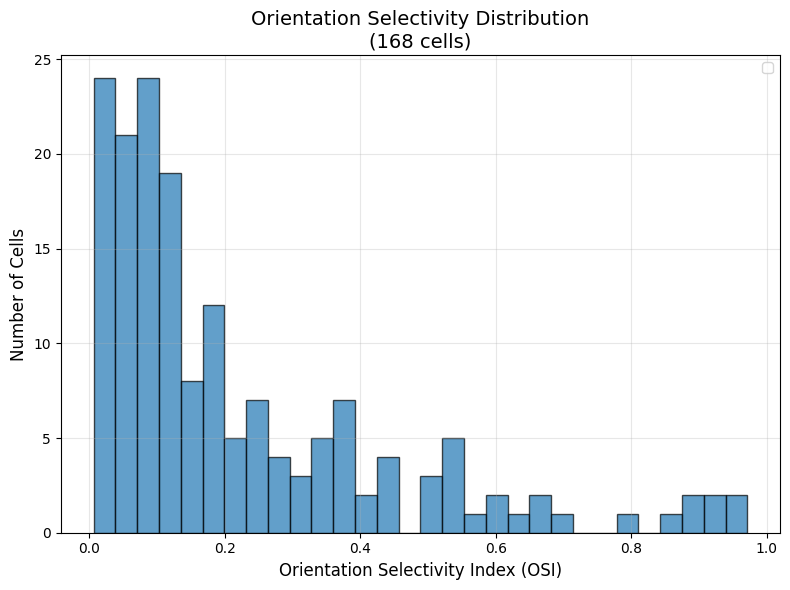

Orientation selective cells: 168 / 188 (89.4%)
Median OSI: 0.128
Mean OSI: 0.221


In [24]:
# Plot OSI distribution 
subset_df = results_df[results_df['unit_id'].isin(units_to_analyze)]
osi_save_path = os.path.join(output_dir, f'osi_distribution_{mode_suffix}.png')
plot_orientation_selectivity(subset_df, n_hist_bins=30, peak_dff_min=1.0, save_path=osi_save_path)

## Look in response + pref

In [25]:
# trial_responses = np.array(trial_responses)
# response[ori_pt, tf_pt, 0] = trial_responses.mean()
# response[ori_pt, tf_pt, 1] = trial_responses.std() / sqrt(len(trial_responses))
# response[ori_pt, tf_pt, 2] = len(trial_responses)

In [26]:
print(response.shape)

(4, 5, 3)


Text(0, 0.5, 'Orientation Frequency Index')

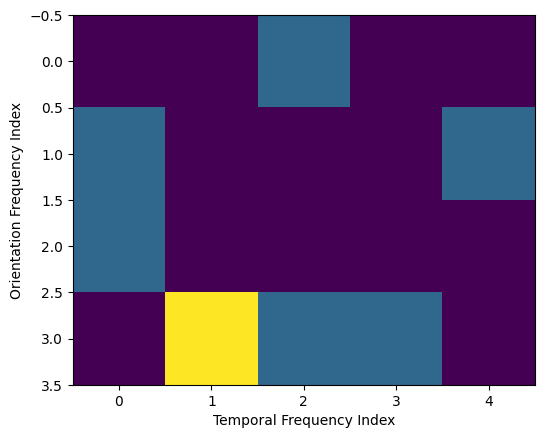

In [27]:
mean = response[:, :, 0]

fig, ax = plt.subplots()
im = ax.imshow(mean)
plt.xlabel('Temporal Frequency Index')  
plt.ylabel('Orientation Frequency Index')

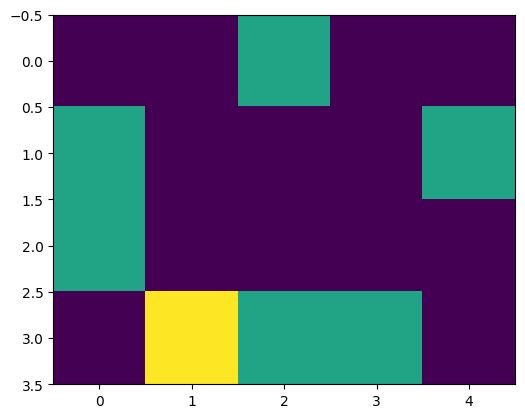

In [28]:
sem = response[:, :, 1]

fig, ax = plt.subplots()
im = ax.imshow(sem)

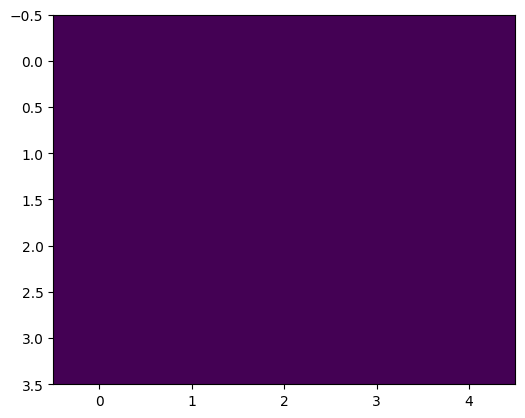

In [29]:
n_trials = response[:, :, 2]

fig, ax = plt.subplots()
im = ax.imshow(n_trials)

In [30]:
# peak['pref'] = pref 
# peak['orth1'] = orth1
# peak['orth2'] = orth2
# peak['null'] = null

pref = peak['pref']
print(pref)

orth1 = peak['orth1']
print(orth1)

orth2 = peak['orth2']
print(orth2)

null = peak['null']
print(null)

0.04
0.0
0.0
0.04
